![image.png](https://miro.medium.com/max/1400/1*5rairMYDqDpTmzytnqpYnQ.jpeg)
[Medium](https://medium.com/@naivetech/the-connection-between-spark-streaming-and-apache-kafka-with-java-9fcdc701a8ad)

![image.png](https://miro.medium.com/max/1400/1*5rairMYDqDpTmzytnqpYnQ.jpeg)
[Medium](https://medium.com/@naivetech/the-connection-between-spark-streaming-and-apache-kafka-with-java-9fcdc701a8ad)

<div class="jumbotron">
    <center>
        <h1>Kafka Data Source for Spark</h1>
    </center>
</div>

https://spark.apache.org/docs/latest/streaming-kafka-integration.html

The Kafka project introduced a new consumer API between versions 0.8 and 0.10, so there are 2 separate corresponding Spark Streaming packages available. Please choose the correct package for your brokers and desired features; note that the 0.8 integration is compatible with later 0.9 and 0.10 brokers, but the 0.10 integration is not compatible with earlier brokers.

Note: Kafka 0.8 support is deprecated as of Spark 2.3.0.


|                            | spark-streaming-kafka-0-8 | spark-streaming-kafka-0-10 |
|----------------------------|---------------------------|----------------------------|
| Broker Version             | 0.8.2.1 or higher         | 0.10.0 or higher           |
| API Maturity               | Deprecated                | Stable                     |
| Language Support           | Scala, Java, Python       | Scala, Java                |
| Receiver DStream           | Yes                       | No                         |
| Direct DStream             | Yes                       | Yes                        |
| SSL / TLS Support          | No                        | Yes                        |
| Offset Commit API          | No                        | Yes                        |
| Dynamic Topic Subscription | No                        | Yes                        |

# spark-streaming-kafka-0-8	

![image.png](https://i.imgflip.com/3zkuk4.jpg)
[NicsMeme](https://imgflip.com/i/3zkuk4)

## Receiver-based Approach

This approach uses a Receiver to receive the data. 

The Receiver is implemented using the Kafka high-level consumer API. As with all receivers, the data received from Kafka through a Receiver is stored in Spark executors, and then jobs launched by Spark Streaming processes the data.

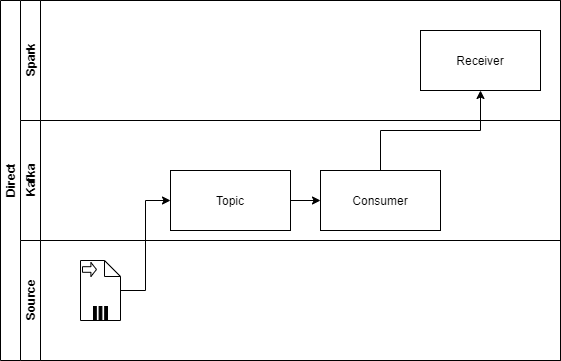

### Linking
For Scala/Java applications using SBT/Maven project definitions, link your streaming application with the following artifact (see Linking section in the main programming guide for further information).

 groupId = org.apache.spark
 artifactId = spark-streaming-kafka_2.10
 version = 1.4.1
 
For Python applications, you will have to add this above library and its dependencies when deploying your application. 

### Programming
```python
from pyspark.streaming.kafka import KafkaUtils
 kafkaStream = KafkaUtils.createStream(streamingContext, \
     [ZK quorum], [consumer group id], [per-topic number of Kafka partitions to consume])
```
By default, the Python API will decode Kafka data as UTF8 encoded strings. You can specify your custom decoding function to decode the byte arrays in Kafka records to any arbitrary data type. See the API docs and the example.

Points to remember:

Topic partitions in Kafka does not correlate to partitions of RDDs generated in Spark Streaming. 
So increasing the number of topic-specific partitions in the KafkaUtils.createStream() only increases the number of threads using which topics that are consumed within a single receiver. It does not increase the parallelism of Spark in processing the data. Refer to the main document for more information on that.

Multiple Kafka input DStreams can be created with different groups and topics for parallel receiving of data using multiple receivers.

If you have enabled Write Ahead Logs with a replicated file system like HDFS, the received data is already being replicated in the log. Hence, the storage level in storage level for the input stream to StorageLevel.MEMORY_AND_DISK_SER (that is, use KafkaUtils.createStream(..., StorageLevel.MEMORY_AND_DISK_SER)).

### Deploying

As with any Spark applications, spark-submit is used to launch your application. However, the details are slightly different for Scala/Java applications and Python applications.

For Scala and Java applications, if you are using SBT or Maven for project management, then package spark-streaming-kafka-0-8_2.12 and its dependencies into the application JAR. Make sure spark-core_2.12 and spark-streaming_2.12 are marked as provided dependencies as those are already present in a Spark installation. Then use spark-submit to launch your application (see Deploying section in the main programming guide).

For Python applications which lack SBT/Maven project management, spark-streaming-kafka-0-8_2.12 and its dependencies can be directly added to spark-submit using --packages (see Application Submission Guide). That is,
```bash
 ./bin/spark-submit --packages org.apache.spark:spark-streaming-kafka-0-8_2.12:2.4.5 ...
 ```
Alternatively, you can also download the JAR of the Maven artifact spark-streaming-kafka-0-8-assembly from the Maven repository and add it to spark-submit with --jars.

## Demo

```bash
# Start Zookeeper
./kafkaStartZk.sh
# Start Kafka Server
./kafkaStartServer.sh
#  Start Spark Streaming
./sparkSubmitPython.sh kafka_wordcount.py org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.5
# Start Producer
./kafkaCreateProducer.sh
```

# Direct Approach (No Receivers)

This new receiver-less “direct” approach has been introduced in Spark 1.3 to ensure stronger end-to-end guarantees. 

Instead of using receivers to receive data, this approach periodically queries Kafka for the latest offsets in each topic+partition, and accordingly defines the offset ranges to process in each batch.

When the jobs to process the data are launched, Kafka’s simple consumer API is used to read the defined ranges of offsets from Kafka (similar to read files from a file system). 

Note that this feature was introduced in Spark 1.3 for the Scala and Java API, in Spark 1.4 for the Python API.

This approach has the following advantages over the receiver-based approach (i.e. Approach 1).

**Simplified Parallelism**

No need to create multiple input Kafka streams and union them. 

With directStream, Spark Streaming will create as many RDD partitions as there are Kafka partitions to consume, which will all read data from Kafka in parallel. 

So there is a one-to-one mapping between Kafka and RDD partitions, which is easier to understand and tune.

**Efficiency**

Achieving zero-data loss in the first approach required the data to be stored in a Write-Ahead Log, which further replicated the data. 

This is actually inefficient as the data effectively gets replicated twice - once by Kafka, and a second time by the Write-Ahead Log. 

This second approach eliminates the problem as there is no receiver, and hence no need for Write-Ahead Logs. 

As long as you have sufficient Kafka retention, messages can be recovered from Kafka.

**Exactly-once semantics**

The first approach uses Kafka’s high-level API to store consumed offsets in Zookeeper. 
This is traditionally the way to consume data from Kafka. 
While this approach (in combination with-write-ahead logs) can ensure zero data loss (i.e. at-least once semantics), there is a small chance some records may get consumed twice under some failures. 
This occurs because of inconsistencies between data reliably received by Spark Streaming and offsets tracked by Zookeeper. 

Hence, in this second approach, we use simple Kafka API that does not use Zookeeper. Offsets are tracked by Spark Streaming within its checkpoints. This eliminates inconsistencies between Spark Streaming and Zookeeper/Kafka, and so each record is received by Spark Streaming effectively exactly once despite failures. In order to achieve exactly-once semantics for output of your results, your output operation that saves the data to an external data store must be either idempotent, or an atomic transaction that saves results and offsets (see Semantics of output operations in the main programming guide for further information).

Note that one disadvantage of this approach is that it does not update offsets in Zookeeper, hence Zookeeper-based Kafka monitoring tools will not show progress. However, you can access the offsets processed by this approach in each batch and update Zookeeper yourself (see below).

### Linking
This approach is supported only in Scala/Java application. Link your SBT/Maven project with the following artifact (see Linking section in the main programming guide for further information).

```properties
 groupId = org.apache.spark
 artifactId = spark-streaming-kafka-0-8_2.12
 version = 2.4.5
 ```
 In the streaming application code, import KafkaUtils and create an input DStream as follows.

### Programming
```python
 from pyspark.streaming.kafka import KafkaUtils
 directKafkaStream = KafkaUtils.createDirectStream(ssc, [topic], {"metadata.broker.list": brokers})
```

You can also pass a messageHandler to createDirectStream to access KafkaMessageAndMetadata that contains metadata about the current message and transform it to any desired type. By default, the Python API will decode Kafka data as UTF8 encoded strings. You can specify your custom decoding function to decode the byte arrays in Kafka records to any arbitrary data type. See the API docs.

In the Kafka parameters, you must specify either metadata.broker.list or bootstrap.servers. 

By default, it will start consuming from the latest offset of each Kafka partition. 

If you set configuration auto.offset.reset in Kafka parameters to smallest, then it will start consuming from the smallest offset.
You can also start consuming from any arbitrary offset using other variations of KafkaUtils.createDirectStream. 

Furthermore, if you want to access the Kafka offsets consumed in each batch, you can do the following.

```python
 offsetRanges = []

 def storeOffsetRanges(rdd):
     global offsetRanges
     offsetRanges = rdd.offsetRanges()
     return rdd

 def printOffsetRanges(rdd):
     for o in offsetRanges:
         print "%s %s %s %s" % (o.topic, o.partition, o.fromOffset, o.untilOffset)

 directKafkaStream \
     .transform(storeOffsetRanges) \
     .foreachRDD(printOffsetRanges)
```

You can use this to update Zookeeper yourself if you want Zookeeper-based Kafka monitoring tools to show progress of the streaming application.

## Deploying ##
This is same as the first approach.

# Demo

```bash
# Start Zookeeper
./kafkaStartZk.sh
# Start Kafka Server
./kafkaStartServer.sh
#  Start Spark Streaming
./sparkSubmitPython.sh direct_kafka_wordcount.py org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.5
# Start Producer
./kafkaCreateProducer.sh
```

# Flume + Kafka + Python

# Draw IO

```bash
# Start Zookeeper
./kafkaStartZk.sh
# Start Kafka Server
./kafkaStartServer.sh
#  Start Spark Streaming
./sparkSubmitPython.sh twitter_stream.py org.apache.spark:spark-streaming-kafka-0-8_2.11:2.4.5
# Start Producer
./flumeTwitterKafka.sh
```

# An example in Java

```bash
# Compile
cd Dev/tap/spark/apps/TapSparkDemo
mvn build
# Start Zookeeper
./kafkaStartZk.sh
# Start Kafka Server
./kafkaStartServer.sh
#  Start Spark Streaming
./sparkSubmitApps.sh TapSpark TapSparkDemo/target/simple-project-1.0.jar org.apache.spark:spark-streaming-kafka-0-10_2.11:2.4.5
# Start Producer
./flumeTwitterKafka.sh
```

## Evolution...
* Create action start master 
* Expose
* submit from host 
https://spark.apache.org/docs/latest/spark-standalone.html

# Biblio

* https://spark.apache.org/docs/latest/streaming-kafka-integration.html
* https://medium.com/@naivetech/the-connection-between-spark-streaming-and-apache-kafka-with-java-9fcdc701a8ad
* https://medium.com/@kass09/spark-streaming-kafka-in-python-a-test-on-local-machine-edd47814746
* https://medium.com/@mukeshkumar_46704/getting-streaming-data-from-kafka-with-spark-streaming-using-python-9cd0922fa904
* https://medium.com/@rinu.gour123/apache-kafka-spark-streaming-integration-af7bd87887fb
* https://data-flair.training/blogs/kafka-spark-streaming-integration/
* http://davidiscoding.com/real-time-twitter-analysis-3-tweet-analysis-on-spark